In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [105]:
regimes = pd.read_csv('monthly_regimes.csv', index_col=0, parse_dates=True)
factors_df = pd.read_csv('all_factors.csv', index_col=0, parse_dates=True)

regimes['LaggedRegime'] = regimes['Regime'].shift(1)

print(regimes.head())
print(factors_df.head())

            Regime  LaggedRegime
Date                            
1989-12-31       1           NaN
1990-01-31       1           1.0
1990-02-28       1           1.0
1990-03-31       1           1.0
1990-04-30       1           1.0
            Mkt-RF   SMB   HML   RMW   CMA    RF   Mom
Date                                                  
1963-07-31   -0.39 -0.48 -0.81  0.64 -1.15  0.27  1.01
1963-08-31    5.08 -0.80  1.70  0.40 -0.38  0.25  1.00
1963-09-30   -1.57 -0.43  0.00 -0.78  0.15  0.27  0.12
1963-10-31    2.54 -1.34 -0.04  2.79 -2.25  0.29  3.13
1963-11-30   -0.86 -0.85  1.73 -0.43  2.27  0.27 -0.78


In [106]:

factors_df.index = pd.to_datetime(factors_df.index)
merged = factors_df.merge(regimes[['LaggedRegime']], left_index=True, right_index=True, how='inner')
merged.dropna(subset=['LaggedRegime'], inplace=True)
merged['LaggedRegime'] = merged['LaggedRegime'].astype(int)
print(merged.head())

            Mkt-RF   SMB   HML   RMW   CMA    RF   Mom  LaggedRegime
Date                                                                
1990-01-31   -7.80 -1.21  0.83 -1.12  1.40  0.57 -2.98             1
1990-02-28    1.11  1.15  0.65 -0.04 -0.61  0.57 -0.51             1
1990-03-31    1.83  1.59 -2.90  1.99 -0.94  0.64  1.72             1
1990-04-30   -3.36 -0.35 -2.57  1.78 -1.00  0.69  2.28             1
1990-05-31    8.44 -2.41 -3.89  1.68 -1.63  0.68  3.14             1


In [107]:
print(merged.groupby('LaggedRegime').mean().round(4))


              Mkt-RF     SMB     HML     RMW     CMA      RF     Mom
LaggedRegime                                                        
0             0.8748  0.0171  0.0491  0.3053  0.0599  0.0615  0.1985
1             0.8093 -0.2629  0.0859  0.4116  0.0489  0.4290  0.8315
2             0.6214  0.4221  0.5173  0.3447  0.3821  0.1256  0.4962
3            -0.6415 -0.0746 -3.1923  0.5562 -0.4485  0.0231 -3.0023


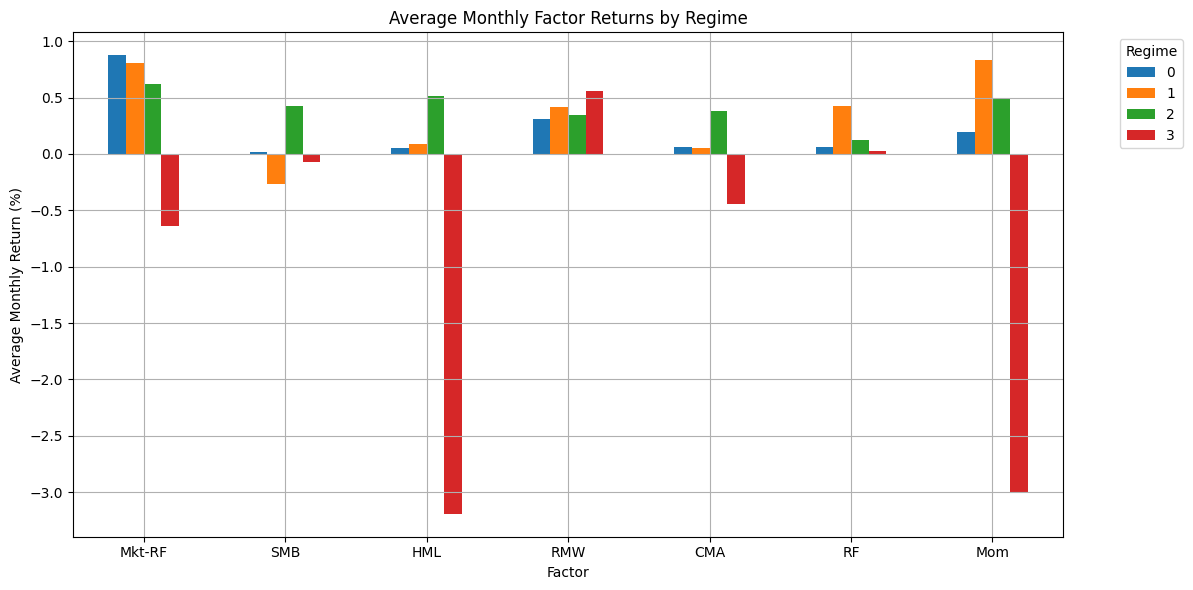

In [108]:
# Plot average monthly factor returns by regime
factor_columns = merged.columns[:-1]  # Exclude LaggedRegime
mean_returns = merged.groupby('LaggedRegime')[factor_columns].mean()

mean_returns.T.plot(kind='bar', figsize=(12, 6))
plt.title('Average Monthly Factor Returns by Regime')
plt.xlabel('Factor')
plt.ylabel('Average Monthly Return (%)')
plt.grid(True)
plt.xticks(rotation=0)
plt.legend(title='Regime', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

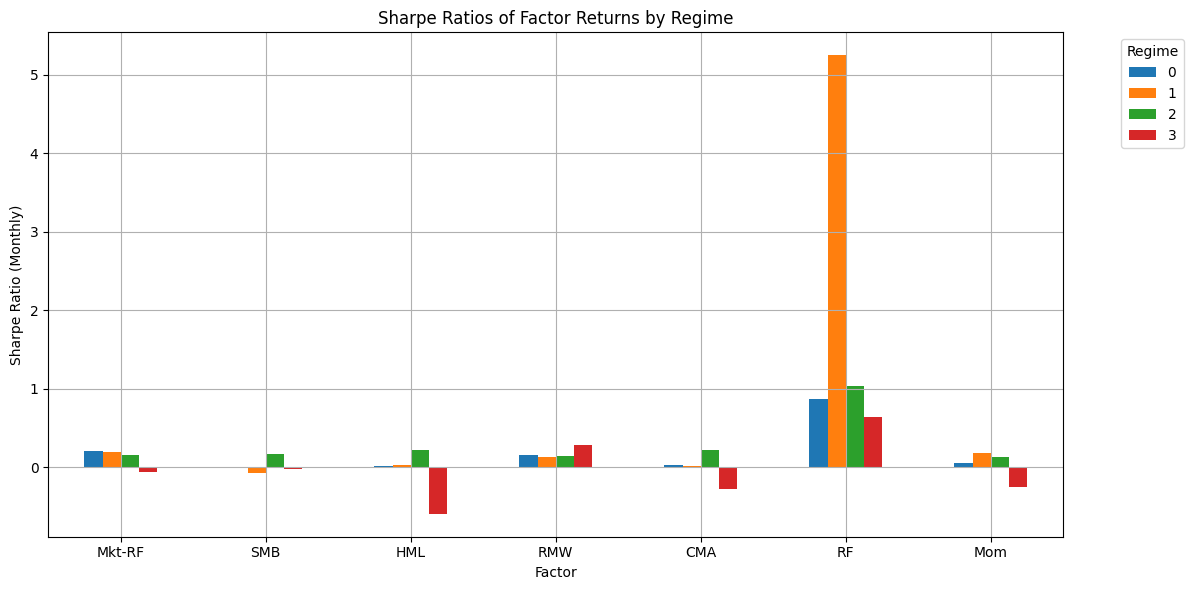

In [109]:
# Plot Sharpe Ratios by regime
sharpe_ratios = merged.groupby('LaggedRegime')[factor_columns].mean() / merged.groupby('LaggedRegime')[factor_columns].std()

sharpe_ratios.T.plot(kind='bar', figsize=(12, 6))
plt.title('Sharpe Ratios of Factor Returns by Regime')
plt.xlabel('Factor')
plt.ylabel('Sharpe Ratio (Monthly)')
plt.grid(True)
plt.xticks(rotation=0)
plt.legend(title='Regime', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [110]:
factors = [col for col in merged.columns if col not in ['LaggedRegime']]
window = 2  # You can adjust: number of months for rolling window

strategy_returns = []

# Convert index to sorted datetime to ensure correct ordering
merged = merged.sort_index()

for i in range(window, len(merged)):
    past = merged.iloc[:i]  # Data up to, but not including, time i
    current = merged.iloc[i]
    current_regime = current['LaggedRegime']
    
    # Filter past data with same regime
    past_same_regime = past[past['LaggedRegime'] == current_regime]
    
    # Defensive check
    if past_same_regime.empty:
        strategy_returns.append(np.nan)
        continue

    # Sharpe ratio logic
    mean_returns = past_same_regime[factors].mean()
    std_devs = past_same_regime[factors].std()

    sharpe_ratios = mean_returns / std_devs
    sharpe_ratios = sharpe_ratios.replace([np.inf, -np.inf], np.nan).dropna()


    if sharpe_ratios.empty:
        strategy_returns.append(np.nan)
        continue

    # Pick best factors with Top-N weighted strategy
    top_factors = sharpe_ratios.nlargest(3)
    weights = top_factors / top_factors.sum()
    strategy_return = (current[top_factors.index] * weights).sum()
    strategy_returns.append(strategy_return)

    
    # Use that factor’s return today
    # strategy_returns.append(strategy_return)

# Build series with proper datetime index
strategy_series = pd.Series(strategy_returns, index=merged.index[window:])
strategy_cum = (1 + strategy_series / 100).cumprod()


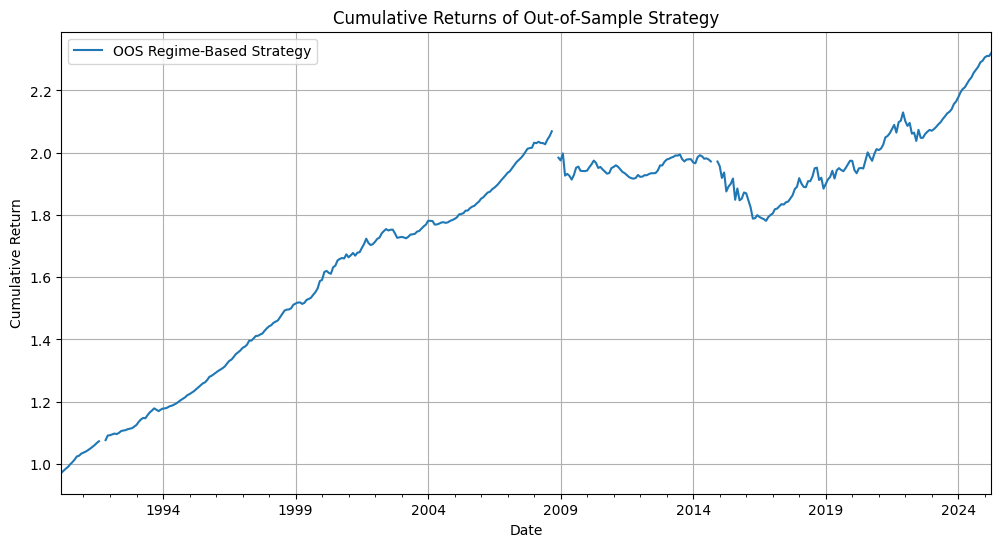

In [111]:
strategy_cum.plot(figsize=(12,6), label='OOS Regime-Based Strategy')
plt.title('Cumulative Returns of Out-of-Sample Strategy')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


In [74]:
# # Simulate a basic regime-based rotation strategy
# best_factor_by_regime = mean_returns.idxmax(axis=1) # Identify the best performing factor in each regime by mean return

# # Build strategy returns based on the best factor for each regime
# strategy_returns = []
# for date, row in merged.iterrows():
#     regime = row['LaggedRegime']
#     best_factor = best_factor_by_regime[regime]
#     strategy_returns.append(row[best_factor])

# # Convert to Series and calculate cumulative returns
# strategy_series = pd.Series(strategy_returns, index=merged.index)
# strategy_cum = (1 + strategy_series/100).cumprod()  # Convert percentage returns to cumulative returns

# # Plot cumulative returns of the strategy
# strategy_cum.plot(figsize=(12, 6))
# plt.plot(strategy_cum, label='Regime Based Strategy')
# plt.title('Cumulative Returns of Regime-Based Factor Rotation Strategy')
# plt.xlabel('Date')
# plt.ylabel('Growth of $1 Investment')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

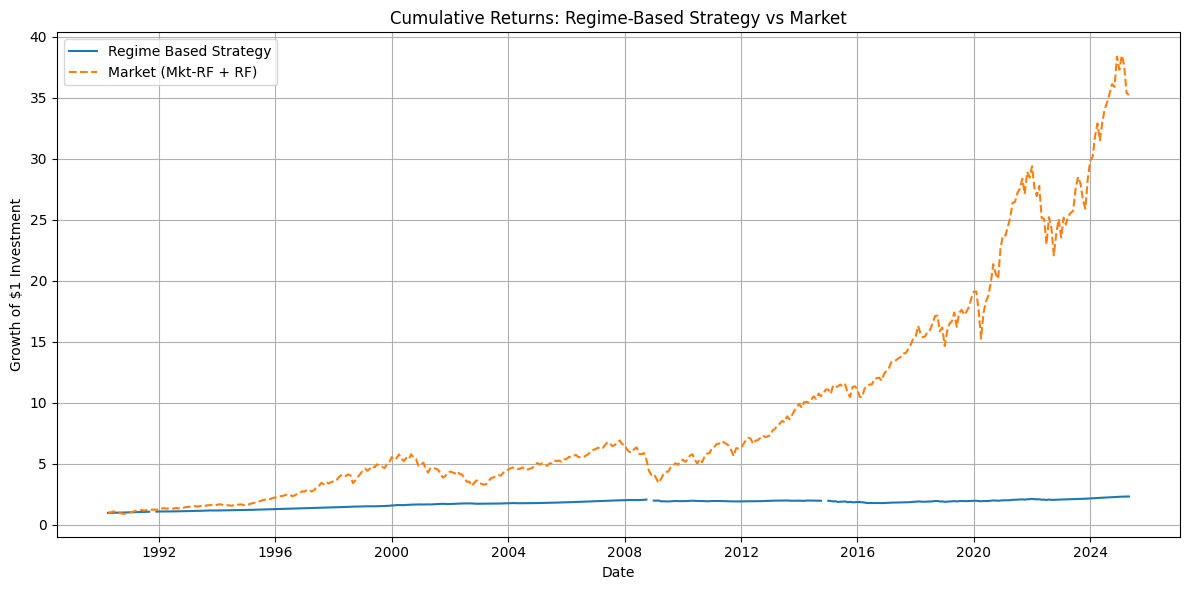

In [112]:
# Compare my regime-based factor rotation strategy against the market (Using Mkt-RF + RF)
merged['Market'] = merged['Mkt-RF'] + merged['RF']

market_cum = (1 + merged['Market']/100).loc[strategy_series.index].cumprod()

plt.figure(figsize=(12, 6))
plt.plot(strategy_cum, label='Regime Based Strategy')
plt.plot(market_cum, label='Market (Mkt-RF + RF)', linestyle='--')
plt.title('Cumulative Returns: Regime-Based Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Growth of $1 Investment')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [113]:
(merged['Mkt-RF'] > merged[factors].mean(axis=1)).mean()


0.589622641509434